In [2]:
import numpy as np
from libpysal.weights import lat2W, Kernel
from numpy.linalg import inv
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors

from sklearn.neighbors import NearestNeighbors
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_blobs
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
from spglm.iwls import _compute_betas_gwr, iwls
from spglm.family import Gaussian
from sklearn.gaussian_process.kernels import RBF
from sklearn.gaussian_process import GaussianProcessRegressor
from statsmodels.api import OLS
from mgwr.gwr import GWR, MGWR
from mgwr.sel_bw import Sel_BW
from mgwr.diagnostics import get_AICc
import libpysal as ps  # Ensure PySAL is installed
from libpysal.weights import DistanceBand, lat2W, Kernel
import geopandas as gpd
from shapely.geometry import Point, Polygon
import pandas as pd
from scipy.stats import pearsonr

from numpy.linalg import inv

import warnings
warnings.filterwarnings('ignore')

In [3]:
# Define function to create tract polygons over the area
def create_tracts(xmin, xmax, ymin, ymax, x_step, y_step):
    polys = []
    ids = []
    id_counter = 0
    for x0 in np.arange(xmin, xmax, x_step):
        for y0 in np.arange(ymin, ymax, y_step):
            x1 = x0 + x_step
            y1 = y0 + y_step
            poly = Polygon([(x0, y0), (x1, y0), (x1, y1), (x0, y1)])
            polys.append(poly)
            ids.append(id_counter)
            id_counter += 1
    gdf = gpd.GeoDataFrame({'tract_id': ids, 'geometry': polys})
    return gdf

# Define grid parameters and create tracts
xmin, xmax = 0, 600
ymin, ymax = 0, 600

# This is the step where I choose the size of the tracts
x_step, y_step = 12.5, 12.5 # Creates a 48x48 grid, resulting in 2304 tracts
tracts_gdf48 = create_tracts(xmin, xmax, ymin, ymax, x_step, y_step)

orig_tracts_gdf48 = create_tracts(xmin, xmax, ymin, ymax, x_step, y_step) # this is important as its used in 16x16 visualiation

In [4]:
def simulate_gradient_S1(N=48, jitter_std=5.0, seed=42):
    np.random.seed(seed)

    # Create regular grid
    x = np.linspace(xmin, xmax, N)
    y = np.linspace(ymin, ymax, N)
    xv, yv = np.meshgrid(x, y)
    xv_flat = xv.flatten()
    yv_flat = yv.flatten()

    # Add jitter to simulate real-world irregularity
    x_jittered = xv_flat + np.random.normal(scale=jitter_std, size=xv_flat.shape)
    y_jittered = yv_flat + np.random.normal(scale=jitter_std, size=yv_flat.shape)
    loc1 = np.vstack((x_jittered, y_jittered)).T

    # Create gradient covariate from left (low X) to right (high X)
    gradient_values = (xv_flat - xmin) / (xmax - xmin) * 100

    # Add tiny noise for realism
    value_jitter = np.random.normal(scale=0.05, size=gradient_values.shape)
    S1 = gradient_values + value_jitter

    return S1, loc1

# Generate S1
S1, loc1 = simulate_gradient_S1()

S2 = tracts_gdf48
loc2 = np.array([[point.x, point.y] for point in S2.geometry.centroid])

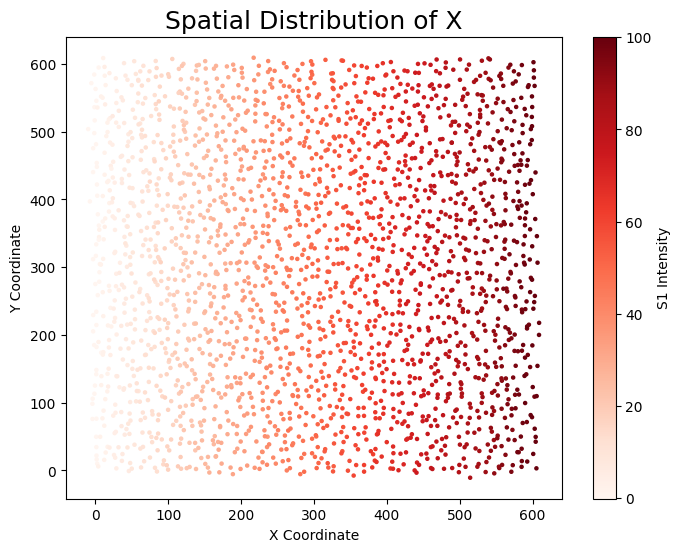

In [8]:
plt.figure(figsize=(8, 6))
# tracts_gdf48.boundary.plot(edgecolor="black", linewidth=0.1)  # Plot grid boundaries

# Set colormap to "RdBu_r" 
cmap = plt.cm.Reds

# Scatter plot with diverging colormap
sc = plt.scatter(loc1[:, 0], loc1[:, 1], c=S1, cmap=cmap, edgecolor="face", s=5)

# Add Colorbar
plt.colorbar(sc, label="S1 Intensity")

# Labels and Title
plt.xlabel("X Coordinate")
plt.ylabel("Y Coordinate")
plt.title("Spatial Distribution of X", fontsize=18)

plt.show()

In [ ]:
def NE_to_SW_gradient(Nlat, min_val=0, max_val=5):

    # Create row (Y) and column (X) indices
    rows, cols = np.meshgrid(np.arange(Nlat), np.arange(Nlat), indexing='ij')
    
    # Normalize and invert diagonal direction
    diag_gradient = (rows + (Nlat - 1 - cols)) / (2 * (Nlat - 1))  # NE to SW
    
    # Rescale to desired range
    beta_vals = min_val + (max_val - min_val) * diag_gradient
    return beta_vals.reshape(-1, 1)


# radial_beta = radial_gradient(48, center_value=5, edge_value=1)
gradient_beta = NE_to_SW_gradient(48)


plt.figure(figsize=(10, 8))
tracts_gdf48.boundary.plot(edgecolor="black", linewidth=0.1)  # Plot grid boundaries

# Set colormap to "RdBu_r" (reversed Red-Blue to match the desired effect)
cmap = plt.cm.Reds

# # Scatter plot with diverging colormap
sc = plt.scatter(loc2[:, 0], loc2[:, 1], c=gradient_beta, cmap=cmap, edgecolor=None)

# Add Colorbar
plt.colorbar(sc, label="y Intensity")

# Labels and Title
plt.xlabel("X Coordinate")
plt.ylabel("Y Coordinate")
plt.title("Spatially varying β", fontsize=18)

plt.show()